In [2]:
import ee
import geemap


In [3]:
ee.Initialize()

In [4]:
aoi = ee.Geometry.Polygon(
    [
        [-77.4467, 44.1024],
        [-77.4467, 44.2352],
        [-77.2686, 44.2352],
        [-77.2686, 44.1024],
        [-77.4467, 44.1024],
    ]
)

START = '2017-04-01'
END = '2022-10-31'

# DATES = [(f'{year}-04-01', f'{year}-10-31') for year in range(2017, 2024)]



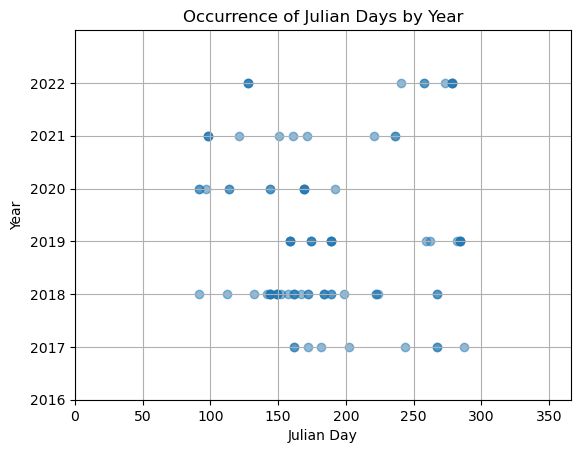

In [5]:
from geeopca.date_time_ploting import make_s2_dt_plots

fig, df = make_s2_dt_plots(aoi, START, END)

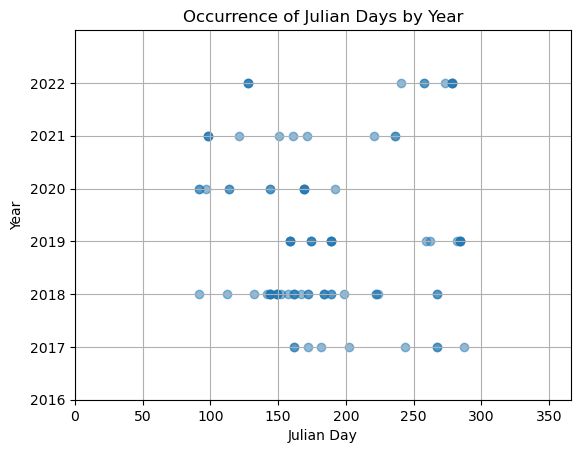

In [6]:
fig

In [12]:
df = df[[col for col in df.columns if col != 'geometry']]

In [15]:
syspaths = df[df['year'] == 2021]['syspath'].tolist()
syspaths

['COPERNICUS/S2_HARMONIZED/20210408T155901_20210408T160051_T17TQJ',
 'COPERNICUS/S2_HARMONIZED/20210408T155901_20210408T160051_T17TQK',
 'COPERNICUS/S2_HARMONIZED/20210408T155901_20210408T160051_T18TUP',
 'COPERNICUS/S2_HARMONIZED/20210501T160901_20210501T161934_T18TUP',
 'COPERNICUS/S2_HARMONIZED/20210531T160901_20210531T161937_T18TUP',
 'COPERNICUS/S2_HARMONIZED/20210610T160901_20210610T161922_T18TUP',
 'COPERNICUS/S2_HARMONIZED/20210620T160901_20210620T161514_T18TUP',
 'COPERNICUS/S2_HARMONIZED/20210809T160901_20210809T161432_T18TUP',
 'COPERNICUS/S2_HARMONIZED/20210824T160829_20210824T161729_T17TQK',
 'COPERNICUS/S2_HARMONIZED/20210824T160829_20210824T161729_T18TUQ']

In [30]:
compute_ndvi = lambda x: x.normalizedDifference(['B8', 'B4']).rename('NDVI')
images = [ee.Image(_) for _ in syspaths]


In [31]:
swm = lambda x: x.expression('(b("B2") + b("B3")) / (b("B8") + b("B11"))').rename('SWM')
swm_images = [swm(_) for _ in images]

In [32]:
import geemap

In [34]:
def get_names(prefix: str, sequence: list[int] | ee.List):
    return ee.List(sequence).map(lambda x: ee.String(prefix).cat(ee.Number(x).int()))

def compute_pca(image: ee.Image) -> ee.Image:
    pc_names = get_names('pc_', ee.List.sequence(1, image.bandNames().size()))
    array_image = image.toArray()
    
    covariance = array_image.reduceRegion(
        **{"reducer": ee.Reducer.covariance(), "maxPixels": 1e13}
    )
    
    covariance_array = ee.Array(covariance.get("array"))

    eigens = covariance_array.eigen()
    eigen_vec = eigens.slice(1, 1)
    principal_compoents = ee.Image(eigen_vec).matrixMultiply(array_image.toArray(1))
    return principal_compoents.arrayProject([0]).arrayFlatten([pc_names])

In [35]:
pca = compute_pca(ndvi)


In [36]:
from geeopca.opca import get_opca_min_max

stats = get_opca_min_max(pca.select('pc_[1-4]'))
stats

In [39]:
pca_vis = {
    'bands': ['pc_1', 'pc_2', 'pc_3'],
    'min': [-0.7662597446028138, -1.9815812662839534, -0.3493066517079054],
    'max': [-2.7670089224936265, -0.5378307176642193, 0.8978706703216206]
}

Map = geemap.Map()

Map.addLayer(pca, pca_vis, 'PCA (pc1, pc2, pc3)')
Map.centerObject(pca, 10)
Map

Map(center=[44.16490077829457, -77.81257159625615], controls=(WidgetControl(options=['position', 'transparent_…